# Klasyfikacja tweetów Elona Muska

### Projekt realizuje grupa:

*  Wiktor Bajor **249459**
*  Adam Kubiak **249480**


### Opis wykonywanego zadania: 

&nbsp; W ramach projektu grupa będzie realizować zadanie klasyfikacji binarnej tweetów Elona Muska. Wykonywane zadanie będzie opierać się o zebranie tweetów sławnych ludzi, takich jak politycy, przedsiębiorcy, sportowcy, celebryci, influencerzy oraz Elon Musk. 
Akwizycja danych będzie realizowana poprzez publiczny interfejs programowania aplikacji (API), udostępniony przez Twitter.  Przy czym możliwa ilość tweetów do pobrania to pięćset tysięcy, co powinno być wystarczającą ilością danych. Dzięki udostępnionemu API można uzyskać dostęp do takich danych jak, treść publikacji, godzina publikacji, lokalizacja, ilość polubień czy ilość retweetów. Po ukończeniu etapu akwizycji danych kolejnym zadaniem, będzie przeanalizowanie tweetów, mając na uwadze takie elementy jak ilość retweetów, ilość polubień, występowanie pewnych słów kluczowych czy też sentyment umieszczonego tekstu. Na podstawie dokonanej analizy zostaną wybrane najbardziej charakterystyczne cechy tweetów Elona Muska. Ostatnim elementem projektu będzie utworzenie i wytrenowanie (na bazie wcześniej wybranych najbardziej istotny cech) klasyfikatora, który będzie oceniał czy dany tweet był napisany przez Elona Muska czy też nie. Wykonana analiza oraz klasyfikator mogłyby zostać wykorzystane do stworzenia cyfrowego sobowtóra Elona Muska. 

In [71]:
import tweepy
import configparser
import pandas as pd
from textblob import TextBlob
import re
import matplotlib.pyplot as plt


def get_all_access_configs():
    config = configparser.RawConfigParser()
    config.read('config.ini')
    config = config['twitter']

    return config.values()

_, _, _, _, bearer_token = get_all_access_configs()

client = tweepy.Client(bearer_token)

In [283]:
user = 'elonmusk'

def fetch_tweets_from_user(user, client):
    id = client.get_user(username=user)
    tweet_fields=['id', 'created_at', 'public_metrics', 'text', 'source', 'possibly_sensitive', 'lang', 'entities', 'context_annotations']

    paginator = tweepy.Paginator(
        method = client.get_users_tweets,
        id = str(id.data.id),
        exclude=['retweets', 'replies'],
        tweet_fields=tweet_fields)

    return [ tweet for tweet in paginator.flatten()]

tweets = fetch_tweets_from_user(user, client)


In [285]:

def clean_tweet(tweet):
    return re.sub(r"http\S+", "", tweet)

def get_tweet_sentiment(tweet):  
        analysis = TextBlob(clean_tweet(tweet.text))
        return [analysis.sentiment.polarity]

def get_basic_tweet_data(tweet):
    return [tweet.id, tweet.created_at, clean_tweet(tweet.text), tweet.source, tweet.possibly_sensitive, tweet.lang]

def get_public_metrics(tweet):
    return tweet.public_metrics.values()

def connect_generated_tweets_data(tweet, functions):
    data_row = []
    for function in functions:
        data_row.extend(function(tweet))
    return data_row

def make_pd_data_frame(tweets, columns, tweet_data_extract_functions):
    data_rows = [ connect_generated_tweets_data(tweet, tweet_data_extract_functions) for tweet in tweets]
    df = pd.DataFrame(data=data_rows, columns=columns)
    df.to_csv('user_data/%s_tweets.csv' % user,index=False)

    return df


In [287]:
columns=[
    'id',
    'created_at',
    'text',
    'source',
    'possibly_sensitive',
    'lang',
    'sentiment',
    'retweet_count',
    'reply_count',
    'like_count',
    'quote_count']
    
tweet_data_extract_functions = [get_basic_tweet_data, get_tweet_sentiment, get_public_metrics]

data_frame = make_pd_data_frame(tweets, columns, tweet_data_extract_functions)
data_frame.head(len(tweets))

,id,created_at,text,source,possibly_sensitive,lang,sentiment,retweet_count,reply_count,like_count,quote_count
0,1586149451348910081,2022-10-29 00:14:33+00:00,"To be super clear, we have not yet made any ch...",Twitter for iPhone,False,en,0.216667,16769,34516,177044,2697
1,1586108809772089345,2022-10-28 21:33:03+00:00,Ligma Johnson had it coming 🍆 💦,Twitter for iPhone,False,en,0.000000,50685,29438,515179,10865
2,1586104694421659648,2022-10-28 21:16:42+00:00,Comedy is now legal on Twitter,Twitter for iPhone,False,en,0.200000,208107,72624,1837428,31565
3,1586059953311137792,2022-10-28 18:18:55+00:00,Twitter will be forming a content moderation c...,Twitter for iPhone,False,en,-0.065625,57752,47085,551488,12851
4,1585966869122457600,2022-10-28 12:09:02+00:00,🎶 let the good times roll 🎶,Twitter for iPhone,False,en,0.700000,91797,47465,943087,7684
...,...,...,...,...,...,...,...,...,...,...,...
701,1486850549928579075,2022-01-27 23:56:10+00:00,And in the darkness bind them,Twitter for iPhone,False,en,0.000000,33017,7840,195867,1545
702,1486846468887560201,2022-01-27 23:39:57+00:00,"If you scare people enough, they will demand r...",Twitter for iPhone,False,en,0.000000,119784,26226,543355,10225
703,1486827458632503297,2022-01-27 22:24:24+00:00,Seems odd that the UN still hasn’t released 20...,Twitter for iPhone,False,en,-0.166667,32801,9128,262124,2128
704,1486806256027422730,2022-01-27 21:00:09+00:00,CB radios are free from govt/media control,Twitter for iPhone,False,en,0.400000,11301,3398,113408,975


In [290]:
def get_value_from_dict(tweet, name='annotations'):
    dict = tweet.entities
    if dict is not None:
        dict = dict.get(name)
        if dict is not None:
            return [ [ dict[0]['probability'], dict[0]['normalized_text'], dict[0]['type'] ] ]
    return []

def get_context_annotations_domain_value(tweet, context_annotations_number=0, key='domain'):
    context_annotations = tweet.context_annotations

    if len(context_annotations) > context_annotations_number:
        return context_annotations[context_annotations_number][key]['name']
    return None

def create_columns_for_annotations_data(number_of_instances=6):
    annotations_columns = []
    for i in range(number_of_instances):
        annotations_columns.extend([f'context_annotations domain {i}', f'context_annotations entity {i}'])
    
    annotations_columns.append('annotations')
    return annotations_columns
    
def get_all_annotations_data(tweet, number_of_instances=6):
    annotations_data = []
    for i in range(number_of_instances):
        annotations_data.extend([
            get_context_annotations_domain_value(tweet, i),
            get_context_annotations_domain_value(tweet, i, 'entity')])
    
    return annotations_data


columns = create_columns_for_annotations_data()

tweet_data_extract_functions = [get_all_annotations_data, get_value_from_dict]

data_frame_annotation = make_pd_data_frame(tweets, columns, tweet_data_extract_functions)
data_frame_annotation.head(len(tweets))


,context_annotations domain 0,context_annotations entity 0,context_annotations domain 1,context_annotations entity 1,context_annotations domain 2,context_annotations entity 2,context_annotations domain 3,context_annotations entity 3,context_annotations domain 4,context_annotations entity 4,context_annotations domain 5,context_annotations entity 5,annotations
0,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,News Vertical,News,News Vertical,Business & finance news,Unified Twitter Taxonomy,Business & finance,Unified Twitter Taxonomy,Tech news,None
1,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,"[0.9745, Ligma Johnson, Person]"
2,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,News Vertical,News,News Vertical,Business & finance news,Unified Twitter Taxonomy,Business & finance,Unified Twitter Taxonomy,Tech news,"[0.971, Twitter, Other]"
3,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,News Vertical,News,News Vertical,Business & finance news,Unified Twitter Taxonomy,Business & finance,Unified Twitter Taxonomy,Tech news,None
4,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Entities [Entity Service],Technology,Unified Twitter Taxonomy,Elon Musk,Unified Twitter Taxonomy,Tech personalities,None
702,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Entities [Entity Service],Technology,Unified Twitter Taxonomy,Elon Musk,Unified Twitter Taxonomy,Tech personalities,None
703,Person,Elon Musk,Brand Vertical,Government/Education,Entities [Entity Service],Non-profit - Government/Education,Brand,United Nations,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,"[0.4915, UN, Organization]"
704,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Entities [Entity Service],Technology,Unified Twitter Taxonomy,Elon Musk,Unified Twitter Taxonomy,Tech personalities,"[0.6201, CB radios, Other]"


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


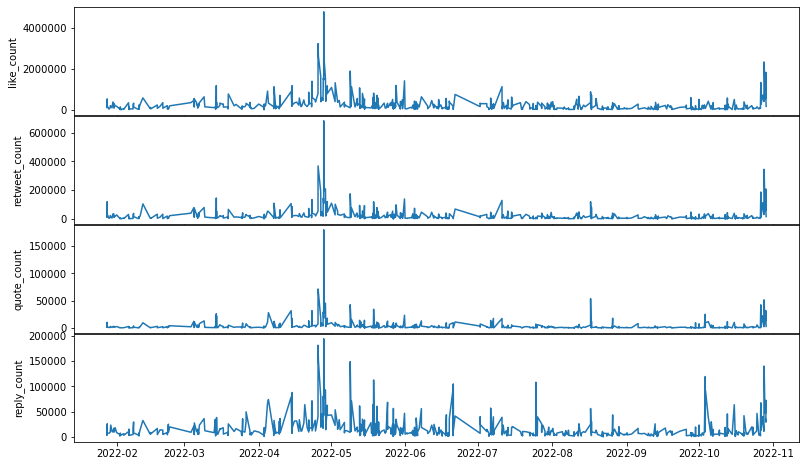

In [289]:
ylabels = ["like_count","retweet_count", 'quote_count', 'reply_count']

fig = plt.figure(figsize=(13,8))
fig.subplots_adjust(hspace=0.01,wspace=0.01)

n_row = len(ylabels)
n_col = 1
for count, ylabel in enumerate(ylabels):
    ax = fig.add_subplot(n_row,n_col,count+1)
    ax.plot(data_frame["created_at"],data_frame[ylabel])
    ax.set_ylabel(ylabel)
plt.show()